In [1]:
# With assistance from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

In [2]:
#transform images
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(220),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.400, 0.400, 0.400], [0.220, 0.220, 0.220])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(250),
        transforms.CenterCrop(220),
        transforms.ToTensor(),
        transforms.Normalize([0.400, 0.400, 0.400], [0.220, 0.220, 0.220])
    ]),
}

data_dir = 'project_object_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'validation']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'validation']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "gpu")

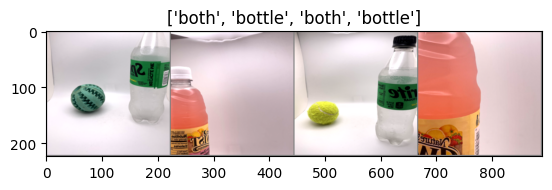

In [3]:
# Helper function to show the images
def image_show(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.500, 0.500, 0.500])
    std = np.array([0.300, 0.300, 0.300])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # allows for plots to update


# Grab training images
inputs, classes = next(iter(dataloaders['train']))

# Create a grid visulization of the training images
out = torchvision.utils.make_grid(inputs)

# Output the grid of training images with image labels
image_show(out, title=[class_names[x] for x in classes])

In [4]:
#Helper function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_weights = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    for epoch in range(num_epochs):
        
        #print output of which epoch is being trained
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # loops for training and validation sets
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate through the images
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero out the optimizer's parameters
                optimizer.zero_grad()

                # keep track of history in training mode
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # If in training mode:
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # run statistics on the training
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_accuracy = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Accuracy: {epoch_accuracy:.4f}')

            # copy the model
            if phase == 'validation' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_weights = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training time: {time_elapsed // 60:.0f}min {time_elapsed % 60:.0f}sec')
    print(f'Best accuracy: {best_accuracy:4f}')

    # load best model weights
    model.load_state_dict(best_weights)
    return model

In [5]:
# Helper function to visualize the model
# Able to change the number of images it outputs as well
def visualize_model(model, num_images=6):
    previously_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                image_show(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=previously_training)
                    return
        model.train(mode=previously_training)

In [7]:
model1 = torchvision.models.resnet18(pretrained=True)
for param in model1.parameters():
    param.requires_grad = False

num_features = model1.fc.in_features
model1.fc = nn.Linear(num_features, 4)

model_trained = model1.to(device)

criteria = nn.CrossEntropyLoss()

# Only tweaking parameters of final layer of the model
optimizer_train = optim.SGD(model_trained.fc.parameters(), lr=0.001, momentum=0.9)

# Decrease LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_train, step_size=7, gamma=0.1)

In [8]:
# Train the model for 25 epochs
model_trained = train_model(model1, criteria, optimizer_train,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.5646 Accuracy: 0.2329
validation Loss: 1.0282 Accuracy: 0.6087

Epoch 1/24
----------
train Loss: 1.2532 Accuracy: 0.4521
validation Loss: 0.6275 Accuracy: 0.7391

Epoch 2/24
----------
train Loss: 1.0194 Accuracy: 0.4384
validation Loss: 0.3533 Accuracy: 1.0000

Epoch 3/24
----------
train Loss: 1.0245 Accuracy: 0.5890
validation Loss: 0.4190 Accuracy: 0.8696

Epoch 4/24
----------
train Loss: 0.9054 Accuracy: 0.6849
validation Loss: 0.2798 Accuracy: 0.9130

Epoch 5/24
----------
train Loss: 0.7620 Accuracy: 0.6986
validation Loss: 0.3204 Accuracy: 0.9130

Epoch 6/24
----------
train Loss: 0.6552 Accuracy: 0.7260
validation Loss: 0.2193 Accuracy: 0.9130

Epoch 7/24
----------
train Loss: 0.7593 Accuracy: 0.6986
validation Loss: 0.2072 Accuracy: 0.9565

Epoch 8/24
----------
train Loss: 0.7686 Accuracy: 0.7123
validation Loss: 0.1452 Accuracy: 1.0000

Epoch 9/24
----------
train Loss: 0.6357 Accuracy: 0.7671
validation Loss: 0.1592 Accuracy: 1.0000



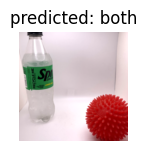

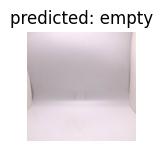

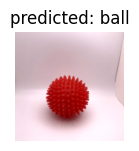

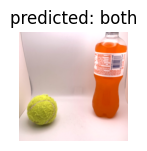

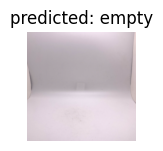

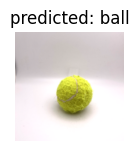

In [9]:
#Show off the predictions
visualize_model(model_trained)

plt.ioff()
plt.show()